In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pandahouse
import numpy as np
from scipy import stats
from tqdm import tqdm
import pylab

In [2]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20220320'
}

def select(q):
    return pandahouse.read_clickhouse(q, connection=connection)

# Часть 1. А/А-тестирование

Запрос CTR с '2022-03-08' по '2022-03-14' для 2 и 3 группы.

In [3]:
df = select("""
SELECT exp_group,
       countIf(action, action='like') likes,
       countIf(action, action='view') views,
       likes/views ctr
       FROM simulator_20220320.feed_actions
WHERE toDate(time) BETWEEN '2022-03-08' AND '2022-03-14'
      AND exp_group IN (2 ,3)
GROUP BY user_id, exp_group""")

In [4]:
df.head()

,exp_group,likes,views,ctr
0,3,11,36,0.305556
1,3,15,92,0.163043
2,2,26,148,0.175676
3,2,12,66,0.181818
4,2,17,120,0.141667


Гисторгамма CTR для 2 и 3 групп пользователей

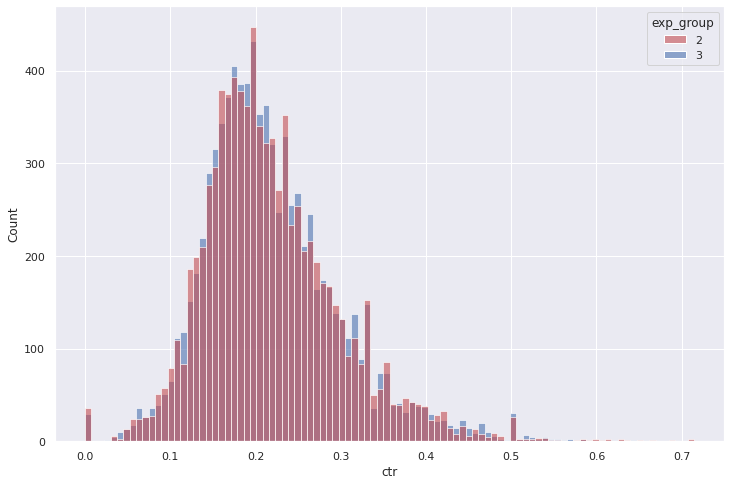

In [5]:
sns.set(rc={'figure.figsize':(12, 8)})
sns.histplot(data=df, x='ctr', hue='exp_group', alpha=0.6, palette = ['r', 'b']);

Проведем t-тест 10000 раз для 500 значений CTR подвыборок из двух групп. p-значения каждого теста сохраняется в списке p_values.

In [6]:
p_values = []

for _ in tqdm(range(10000)):
    a = df[df['exp_group'] == 2]['ctr'].sample(500, replace=True)
    b = df[df['exp_group'] == 2]['ctr'].sample(500, replace=True)
    p_values.append(stats.ttest_ind(a, b, equal_var=False)[1])

100%|██████████| 10000/10000 [00:22<00:00, 445.34it/s]


In [7]:
p_values = pd.Series(p_values)

Гистограмма распределения p-значения

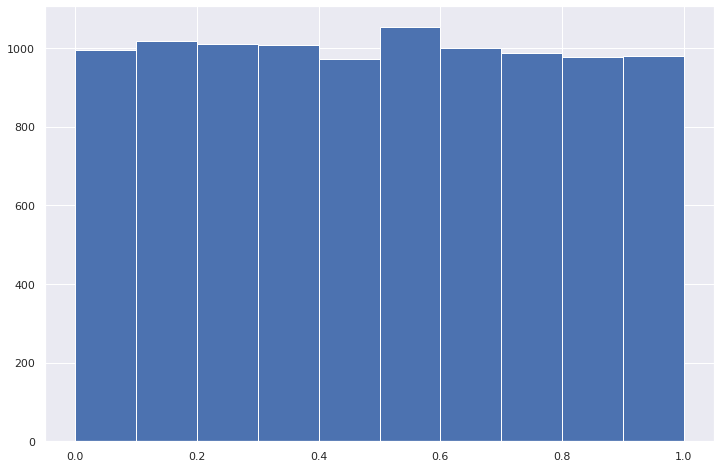

In [8]:
p_values.hist();

Q-Q plot между распределением p-значения и равномерым распределением

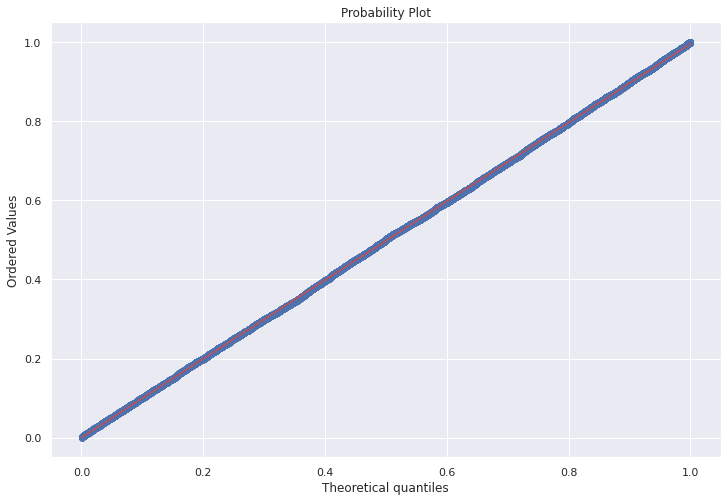

In [9]:
stats.probplot(p_values, dist="uniform", plot=pylab)
pylab.show()

In [10]:
(p_values <= 0.05).mean()

0.0497

По гистограмме и графику Q-Q plot можно утверждать о равномерном распределении p-значения.  
Количество p-значения меньшее или равное 0,05 составляет около 5%.  
Можно сделать вывод, что нет статистически значимых различий между 2 и 3 группами пользователей, система сплитования работает корректно.

# Часть 2. А/В-тестирование

Получим из бд значения CTR с '2022-03-15' по '2022-03-21' для 1 и 2 группы.
группа 1 - контроль
группа 2 - тест (Рекомендации "похожих на лайкнутые постов")

In [11]:
df = select("""
SELECT exp_group,
       countIf(action, action='like') likes,
       countIf(action, action='view') views,
       likes/views ctr
       FROM simulator_20220320.feed_actions
WHERE toDate(time) BETWEEN '2022-03-15' AND '2022-03-21'
      AND exp_group IN (1 ,2)
GROUP BY user_id, exp_group""")

In [12]:
df.head()

,exp_group,likes,views,ctr
0,1,3,15,0.200000
1,1,32,141,0.226950
2,1,18,73,0.246575
3,1,33,122,0.270492
4,1,7,32,0.218750


### t-тест

In [13]:
stats.ttest_ind(df[df['exp_group'] == 1]['ctr'], 
                df[df['exp_group'] == 2]['ctr'],
                equal_var=False, alternative='two-sided')

Ttest_indResult(statistic=0.7094392041270486, pvalue=0.4780623130874935)

Тест Стьюдента не может показать статистически значемого отличия двух группами (p-value=0.48 > 0.05)

### Тест Манна Уитни

In [14]:
stats.mannwhitneyu(df[df['exp_group'] == 1]['ctr'], 
                   df[df['exp_group'] == 2]['ctr'],
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=56601260.5, pvalue=6.0376484617779035e-56)

В отличии от t-теста тест Манна-Уитни находит различия между выборок значимыми.  


При равенстве среднем двух выборок в среднем случайное значение из одной выборки должно    
в 50% случаев быть больше чем во второй.

In [15]:
result = []
for _ in tqdm(range(10000)):
    result.append(df[df.exp_group == 1]['ctr'].sample().values[0] > df[df.exp_group == 2]['ctr'].sample().values[0])

100%|██████████| 10000/10000 [00:22<00:00, 438.26it/s]


In [16]:
result = pd.Series(result)
print('В', result.mean()*100, '% случаев значения из контрольной выборки больше чем в тестовой.')

В 55.510000000000005 % случаев значения из контрольной выборки больше чем в тестовой.


Соотношение отличается от 50%, хотя средние значения двух выборок примерно равны

In [17]:
df[df['exp_group'] == 1]['ctr'].mean(), df[df['exp_group'] == 2]['ctr'].mean()

(0.21560459841296287, 0.21441927347479375)

Посмотрим на распределения двух групп

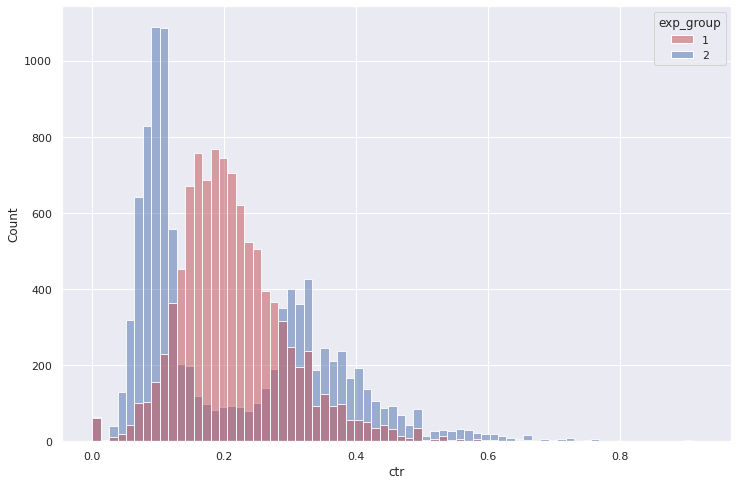

In [18]:
sns.histplot(data=df, x='ctr', hue='exp_group', alpha=0.5, palette = ['r', 'b']);

По гистограмме видны отличия распреления CTR двух групп.  
Контрольная имеет форму близкую к нормальной, тестовая - двухмодальную, несимметричную.  
По графику заметно, что больше значений тестовой группы располагается ниже чем контрольной.  
Подобное размещение распределений и несимметричность тестовой группы приводит к срабатыванию теста Манна-Уитни.   
  
Проверим имеют ли выборочные средние нормальное распредление.

In [19]:
mns_1 = [(df[df['exp_group']==1]['ctr'].sample(1000, replace=True)).mean() for _ in tqdm(range(10000))]

100%|██████████| 10000/10000 [00:10<00:00, 929.32it/s]


In [20]:
mns_2 = [(df[df['exp_group']==2]['ctr'].sample(1000, replace=True)).mean() for _ in tqdm(range(10000))]

100%|██████████| 10000/10000 [00:11<00:00, 908.79it/s]


Распределение выборочных средних для контрольной группы

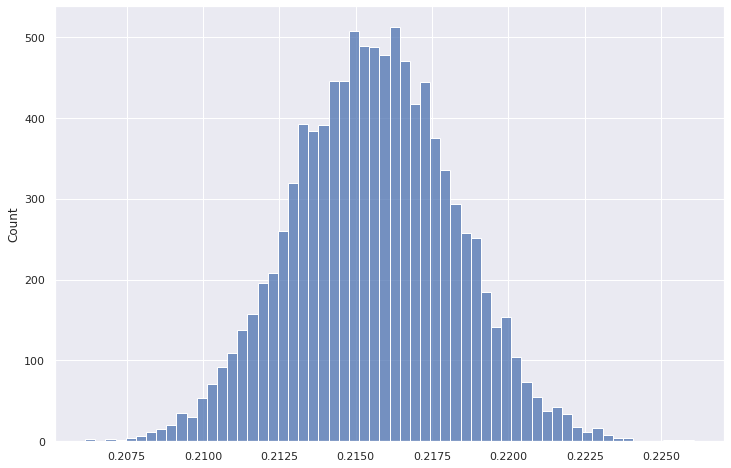

In [21]:
sns.histplot(mns_1);

Q-Q plot между распределением выборочных средних для контрольной группы и нормальным распределением

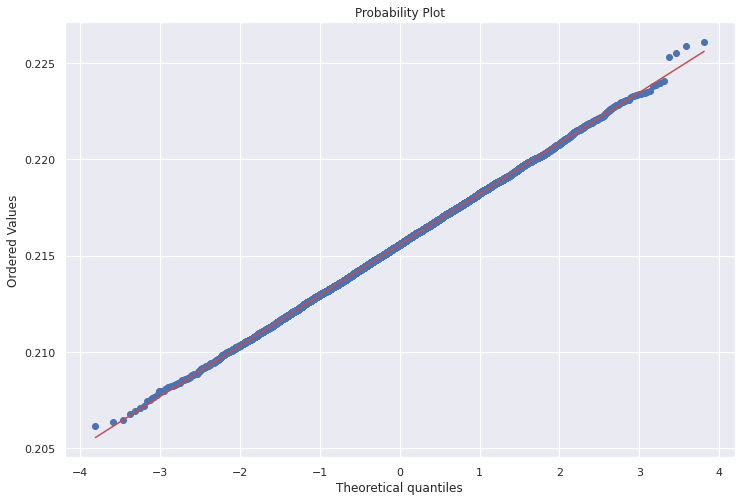

In [22]:
stats.probplot(mns_1, dist="norm", plot=pylab)
pylab.show()

Распределение выборочных средних для тестовой группы

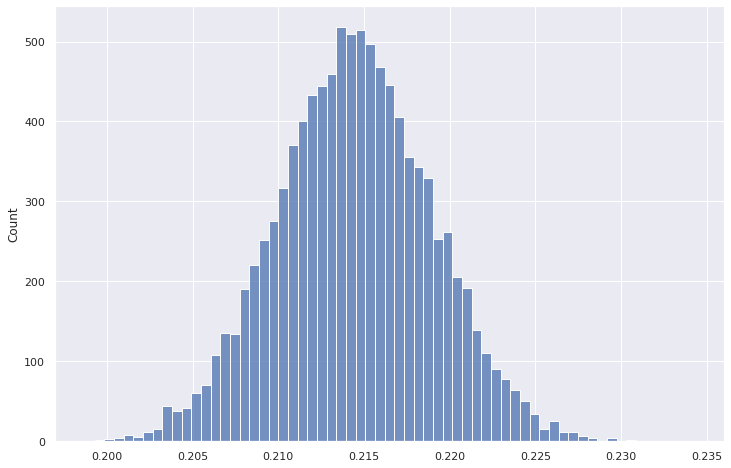

In [23]:
sns.histplot(mns_2);

Q-Q plot между распределением выборочных средних для тестовой группы и нормальным распределением

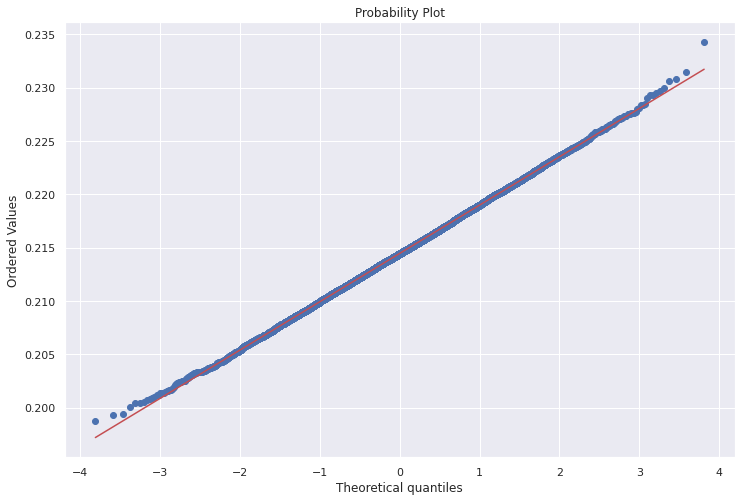

In [24]:
stats.probplot(mns_2, dist="norm", plot=pylab)
pylab.show()

В обеих группах выборочные среднее имеют нормальное распределение

# Сглаживание  CTR

Функция сглаживания СTR 

In [25]:
def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

Рассчет общих CTR для обеих групп

In [26]:
global_ctr_1 = df[df['exp_group'] == 1]['likes'].sum() / df[df['exp_group'] == 1]['views'].sum()
global_ctr_2 = df[df['exp_group'] == 2]['likes'].sum() / df[df['exp_group'] == 2]['views'].sum()

Рассчет сглаженного СTR

In [27]:
df['ctr_smothed'] = df.apply(lambda x: \
                             get_smothed_ctr(x['likes'], x['views'], global_ctr_1, 5) if x['exp_group'] == 1 \
                             else get_smothed_ctr(x['likes'], x['views'], global_ctr_2, 5), axis=1)

Распределение сглаженных CTR.  
Гистограммы стали более сглажены, стало меньше выбросов.

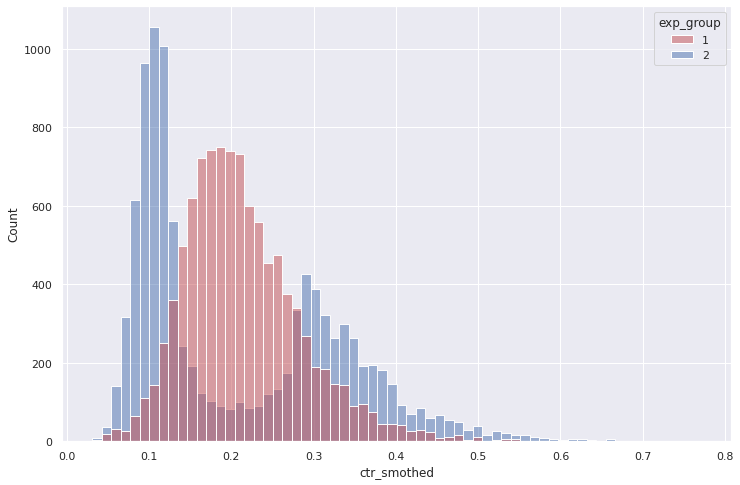

In [28]:
sns.histplot(data=df, x='ctr_smothed', hue='exp_group', alpha=0.5, palette = ['r', 'b']);

Т-тест на сглаженных CTR

In [29]:
stats.ttest_ind(df[df['exp_group'] == 1]['ctr_smothed'], 
                df[df['exp_group'] == 2]['ctr_smothed'],
                equal_var=False, alternative='two-sided')

Ttest_indResult(statistic=2.2841320431616983, pvalue=0.0223769815558559)

Тест Манна-Уитни на сглаженных CTR

In [30]:
stats.mannwhitneyu(df[df['exp_group'] == 1]['ctr_smothed'], 
                   df[df['exp_group'] == 2]['ctr_smothed'],
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=56925125.0, pvalue=1.6163964114270227e-61)

р-значения в обоих тестах упали по сравнению с "чистым" CTR.  
Для Т-теста р-значение составляет 0.02, поэтому можно судить, что различия в группах есть, при выбранном уровне значимости 0.05

In [31]:
result = []
for _ in tqdm(range(10000)):
    result.append(df[df.exp_group == 1]['ctr_smothed'].sample().values[0] > df[df.exp_group == 2]['ctr_smothed'].sample().values[0])

100%|██████████| 10000/10000 [00:23<00:00, 426.79it/s]


In [32]:
result = pd.Series(result)
print('В', result.mean()*100, '% случаев значения из контрольной выборки больше чем в тестовой.')

В 56.28999999999999 % случаев значения из контрольной выборки больше чем в тестовой.


### Пуассоновский бутстреп

Определим функцию, генерирующию подвыборки и рассчитывающих CTR для каждой из групп.   
n_bootstrap - количество подвыборок.

In [33]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=10000):

    poisson_bootstraps1 = np.random.poisson(1, size=(n_bootstrap, len(likes1))).astype(np.int64)
    poisson_bootstraps2 = np.random.poisson(1, size=(n_bootstrap, len(likes2))).astype(np.int64)  
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)   
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2

Рассчитаем бутстрап CTR для 1 и 2 выборки

In [34]:
likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()

ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

Гистораммы распредления подвыборок бутстрап CTR 

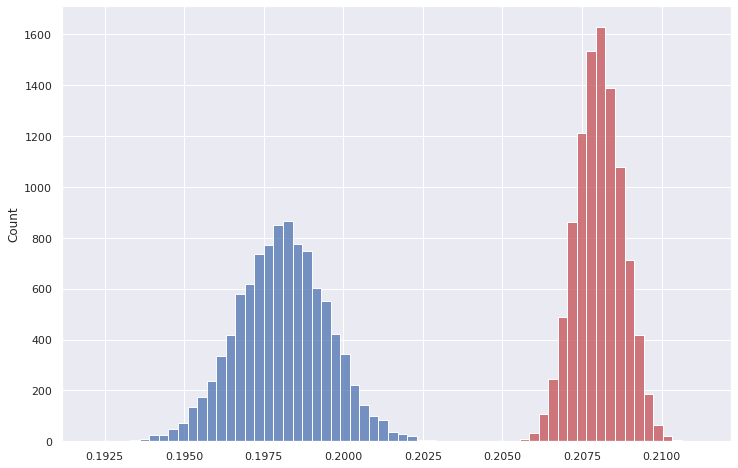

In [35]:
sns.histplot(ctr1, binwidth=0.0003, color=['r'])
sns.histplot(ctr2, binwidth=0.0003);

Гистограмма разности контрольной и тестовой группы.

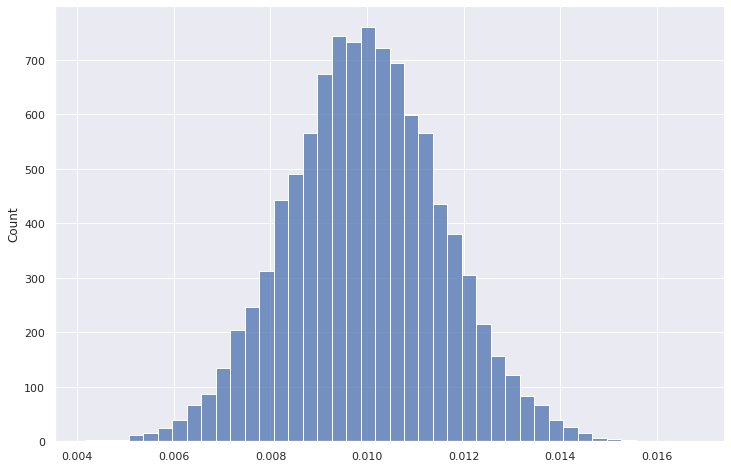

In [36]:
sns.histplot(ctr1 - ctr2, binwidth=0.0003);

In [37]:
(ctr1 - ctr2).min()

0.004164374480633198

По графикам видно, что распределения CTR обеих групп не пересекаются, минимальная разность двух выборок выше 0.  
С большой долей уверености можно говорить о значемом отличии контрольной и тестовой группы.  
Средней прирост CTR - около 0.01%.

In [38]:
ctr1.mean() - ctr2.mean()

0.009955248511439418

### Бакетное преобразование  
  
Запрос для получения значений CTR с '2022-03-15' по '2022-03-21' для 1 и 2 группы, распределенный на 50 бакетов. В каждом бакете около 200 пользователей.

In [39]:
df = select("""
SELECT xxHash64(toString(user_id)||'salt_1')%50 bucket, 
       exp_group,
       countIf(action, action='like') / countIf(action, action='view') ctr
FROM simulator_20220320.feed_actions
WHERE toDate(time) BETWEEN '2022-03-15' AND '2022-03-21'
      AND exp_group IN (1 ,2)
GROUP BY exp_group, bucket""")

Т-тест для бакетов

In [40]:
stats.ttest_ind(df[df['exp_group'] == 1]['ctr'], 
                df[df['exp_group'] == 2]['ctr'],
                equal_var=False, alternative='two-sided')

Ttest_indResult(statistic=7.202583326234558, pvalue=3.204685707747498e-10)

Тест Манна-Уитни для бакетов

In [41]:
stats.mannwhitneyu(df[df['exp_group'] == 1]['ctr'], 
                   df[df['exp_group'] == 2]['ctr'],
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=2089.0, pvalue=7.4493122181865895e-09)

Оба теста подтверждают, что различие в группах есть.  
  
Гистограмма CTR для бакетов  
Видно довольно заметное смещение распределений бакетов тестовой и контрольных групп.

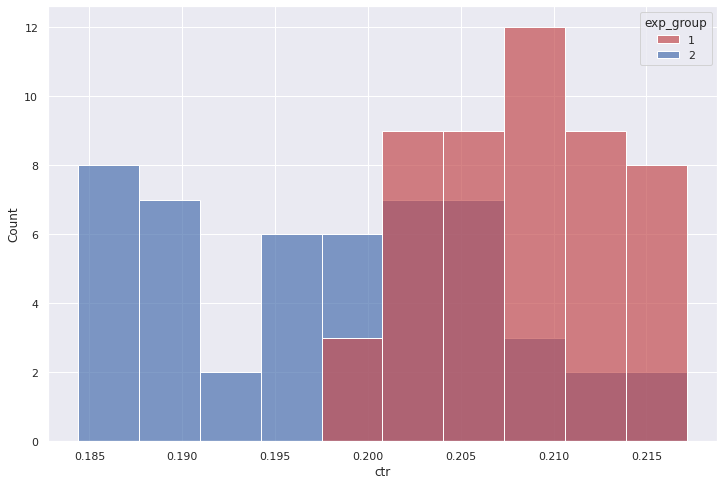

In [42]:
sns.histplot(data=df, x='ctr', hue='exp_group', alpha=0.7, palette = ['r', 'b'], bins=10);

## Вывод

Практически все методы тестирования показывают статистически значимую  разницу между контрольной и тестовой группой.  
Использование нового алгоритма рекомендаций постов приводит к снижению CTR. 
Исключением является тест Стюдента на “чистых” значениях CTR. По всей видимости t-тест имеет   
меньшую чувствительность из-за выбросов в выборках.   
Остальные методы устойчивы к выбросам. Тест Манна-Уитни робастен к выбросам, он учитывает только ранг, а не значение.   
Сглаженный СTR приводит к усреднению значений с небольшим количеством просмотров. Пуассоновский бутстреп и   
бакетное преобразование создает новые выборки с усредненными значениями без больших выбросов.  

Основной причиной выбросов является пользователи с небольшим количеством просмотров. Точность значении СTR   
таких пользователей не надежны. 
Если отбросить часть пользователей с низким числом просмотров, можно избавится от выбросов CTR.

In [43]:
df = select("""
SELECT exp_group,
       countIf(action, action='like') likes,
       countIf(action, action='view') views,
       likes/views ctr
       FROM simulator_20220320.feed_actions
WHERE toDate(time) BETWEEN '2022-03-15' AND '2022-03-21'
      AND exp_group IN (1 ,2)
GROUP BY user_id, exp_group""")

Предположим, что с 20-ого просмотра значение СTR можно считать точным.

In [44]:
print(f"Тогда для теста {(100 * len(df[df['views'] > 20]) / len(df)):.2f}% используем первоначальных данных")

Тогда для теста 86.89% используем первоначальных данных


In [45]:
df_clean = df[df['views'] > 20]
df_outl = df[df['views'] <= 20]

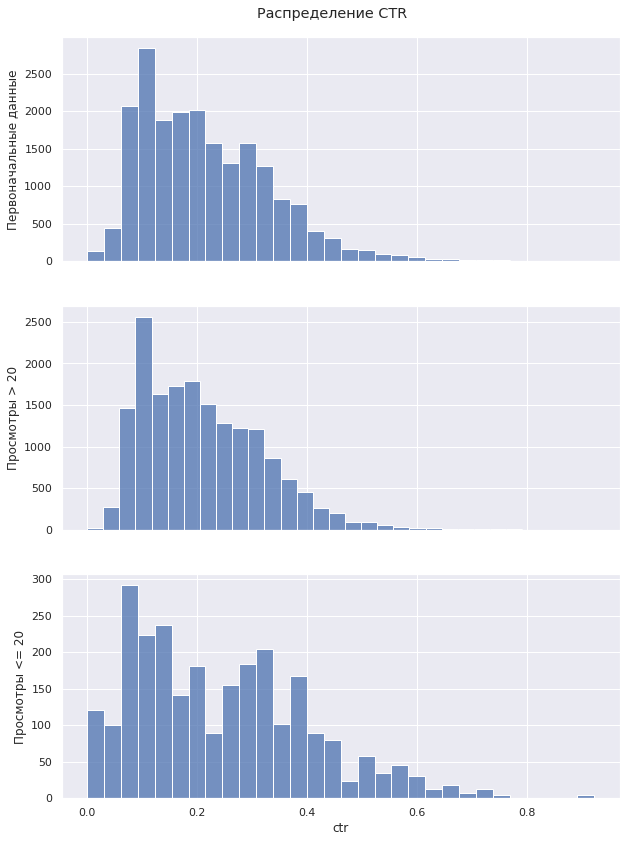

In [46]:
fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(10,14))
plt.suptitle('Распределение CTR', y=.91)

sns.histplot(df['ctr'], bins=30, ax=ax[0])
ax[0].set_ylabel('Первоначальные данные')

sns.histplot(df_clean['ctr'], bins=30, ax=ax[1])
ax[1].set_ylabel('Просмотры > 20')

sns.histplot(df_outl['ctr'], bins=30, ax=ax[2])
ax[2].set_ylabel('Просмотры <= 20');

Заметно, что на отчищенных данных стал короче правый хвост, и уменшилось количество околонулевых значений.  
Проведем t-тест над новыми данными.

In [47]:
stats.ttest_ind(df_clean[df_clean['exp_group'] == 1]['ctr'], 
                df_clean[df_clean['exp_group'] == 2]['ctr'],
                equal_var=False, alternative='two-sided')

Ttest_indResult(statistic=3.24246088397487, pvalue=0.0011879225266990955)

На очищенных данных t-тест показывает статистически значимое отличие контрольной и тестовой групп.

По результатам тестирования можно сделать вывод, что использование нового алгоритма   
рекомендаций постов в среднем снижает CTR в группе. Но, глядя на распределение СTR  
тестовой группы, можно сделать предположение, что для меньшей части пользователей   
новый алгоритм повышает CTR.  
Возможно провести анализ или сделать классификатор для каких пользователей новый алгоритм  
понижает, а для каких повышает CTR. И затем провести новое исследование алгоритма на   
пользователей с положительной реакцией

# Часть 3. Линеаризованные лайки. Метод из Яндекса

Получим данные CTR с '2022-03-15' по '2022-03-21' для групп 0 (контрольная) и 3 (тестовая)

In [48]:
df = select("""
SELECT exp_group,
       countIf(action, action='like') likes,
       countIf(action, action='view') views,
       likes/views ctr
       FROM simulator_20220320.feed_actions
WHERE toDate(time) BETWEEN '2022-03-15' AND '2022-03-21'
    AND exp_group IN (0, 3)
GROUP BY user_id, exp_group""")

Рассчитаем общий CTR для 0 группы

In [49]:
ctr_control_0 = df[df['exp_group'] == 0]['likes'].sum() / df[df['exp_group'] == 0]['views'].sum()

Рассчитаем линеаризованные лайки

In [50]:
df['lenearized_likes'] = df['likes'] - ctr_control_0 * df['views']

Т-тест для CTR

In [51]:
stats.ttest_ind(df[df['exp_group'] == 0]['ctr'], 
                df[df['exp_group'] == 3]['ctr'],
                equal_var=False, alternative='two-sided')

Ttest_indResult(statistic=-13.896870721904069, pvalue=1.055849414662529e-43)

Т-тест для линеаризованных лайков

In [52]:
stats.ttest_ind(df[df['exp_group'] == 0]['lenearized_likes'], 
                df[df['exp_group'] == 3]['lenearized_likes'],
                equal_var=False, alternative='two-sided')

Ttest_indResult(statistic=-15.214995460903827, pvalue=5.4914249479690016e-52)

Оба теста показывают значимое отличия двух групп, p-значение для линеаризованных лайков меньше, чем для CTR

Тест Манна-Уитни для CTR

In [53]:
stats.mannwhitneyu(df[df['exp_group'] == 0]['ctr'], 
                   df[df['exp_group'] == 3]['ctr'],
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=43682792.0, pvalue=1.1952055473582936e-57)

Тест Манна-Уитни для линеаризованных лайков

In [54]:
stats.mannwhitneyu(df[df['exp_group'] == 0]['lenearized_likes'], 
                   df[df['exp_group'] == 3]['lenearized_likes'],
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=43338326.0, pvalue=1.1517315029786597e-63)

Оба теста показывают значимое отличия двух групп, p-значение для линеаризованных лайков меньше, чем для CTR

Распределение линеаризованных лайков для 0 и 3 группы

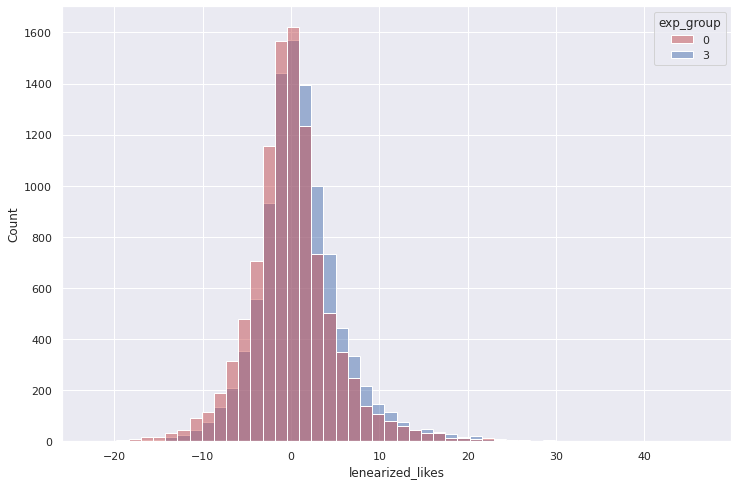

In [55]:
sns.histplot(data=df, x='lenearized_likes', hue='exp_group', alpha=0.5, palette = ['r', 'b'], bins=50);

Проведем аналогичный анализ для 1 (контроль) и 2 (тест) группы

In [56]:
df = select("""
SELECT exp_group,
       countIf(action, action='like') likes,
       countIf(action, action='view') views,
       likes/views ctr
       FROM simulator_20220320.feed_actions
WHERE toDate(time) BETWEEN '2022-03-15' AND '2022-03-21'
    AND exp_group IN (1, 2)
GROUP BY user_id, exp_group""")

In [57]:
ctr_control_0 = df[df['exp_group'] == 1]['likes'].sum() / df[df['exp_group'] == 1]['views'].sum()

In [58]:
df['lenearized_likes'] = df['likes'] - ctr_control_0 * df['views']

Т-тест для CTR

In [59]:
stats.ttest_ind(df[df['exp_group'] == 1]['ctr'], 
                df[df['exp_group'] == 2]['ctr'],
                equal_var=False, alternative='two-sided')

Ttest_indResult(statistic=0.7094392041270486, pvalue=0.4780623130874935)

Т-тест для линеаризованных лайков

In [60]:
stats.ttest_ind(df[df['exp_group'] == 1]['lenearized_likes'], 
                df[df['exp_group'] == 2]['lenearized_likes'],
                equal_var=False, alternative='two-sided')

Ttest_indResult(statistic=6.122579994775973, pvalue=9.439432187037712e-10)

Для линеаризованных лайков в отличии от СTR есть значимое отличие двух групп  
p-значение для линеаризованных лайков меньше, чем для CTR

Тест Манна-Уитни для CTR

In [61]:
stats.mannwhitneyu(df[df['exp_group'] == 1]['ctr'], 
                   df[df['exp_group'] == 2]['ctr'],
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=56601260.5, pvalue=6.0376484617779035e-56)

Тест Манна-Уитни для линеаризованных лайков

In [62]:
stats.mannwhitneyu(df[df['exp_group'] == 1]['lenearized_likes'], 
                   df[df['exp_group'] == 2]['lenearized_likes'],
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=54534537.0, pvalue=9.404319579641738e-27)

Оба теста показывают значимое отличия двух групп, p-значение для линеаризованных лайков больше, чем для CTR

Распределение линеаризованных лайков для 1 и 2 группы

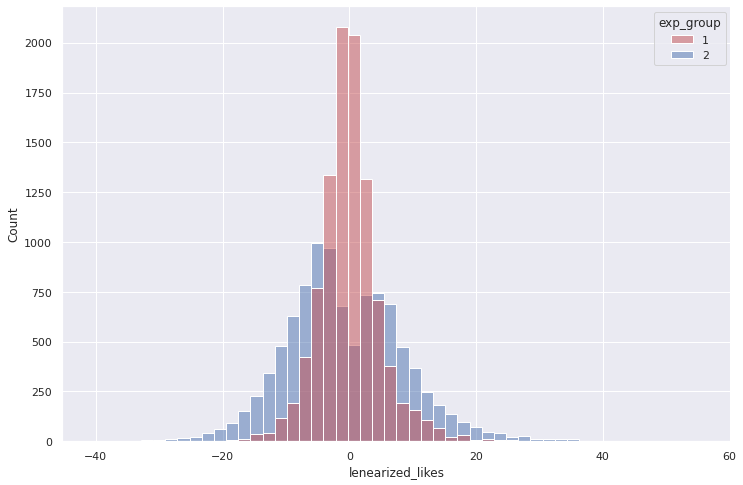

In [63]:
sns.histplot(data=df, x='lenearized_likes', hue='exp_group', alpha=0.5, palette = ['r', 'b'], bins=50);